In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import plotly.express as px
from statsmodels.tsa.seasonal import STL

In [2]:
df = pd.read_table(r"Данные\400С_5.txt",  decimal=',')
format_data = "%m%d%y_%H%M%S"

df["Time"] = df.Timestamp.apply( lambda x: datetime.strptime(x, format_data))
df["Time"] = df["Time"] - df["Time"][0]
df["Time"] = df["Time"].dt.total_seconds()
df["Shutter"] = df.Shutter.shift(-23)


for i in range(int(df.Time[df.index[-1]])):
    pattern = np.linspace(0,1,len(df[df.Time == i]))
    df.loc[df.Time == i, "Time"] += pattern
df = df.loc[df.Wavelength >= 300][["Time", "Current", "Wavelength", "Shutter"]].copy(deep=True)
px.line(df, "Time", ["Current"])

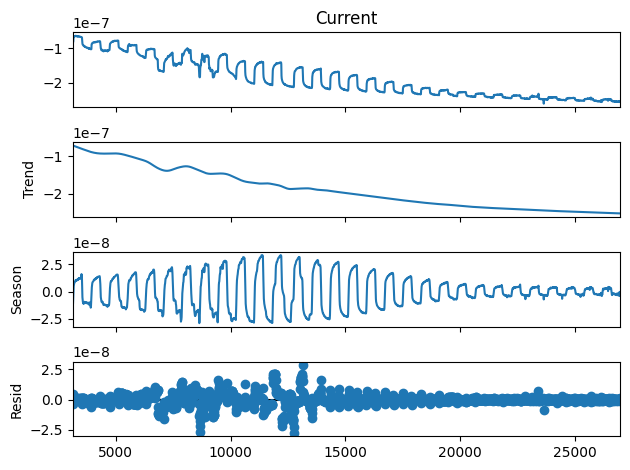

In [3]:
n = 10
rolling_mean = df['Current'].ewm(alpha=0.2, adjust=False).mean()
df_resampled = pd.DataFrame({'Time': df['Time'].iloc[::n], 'Current': rolling_mean[::n], 'Wavelength': df['Wavelength'].iloc[::n], "Shutter":  df['Shutter'].iloc[::n]})
stl = STL(df_resampled.Current.dropna(), period=int(800/n))
res = stl.fit()
fig = res.plot()

In [4]:
df_resampled["Photocurrent"] = res.seasonal
df_resampled["Photocurrent_uA"] = df_resampled.Photocurrent*1E8
px.line(df_resampled, "Time", ["Photocurrent_uA", "Shutter"])

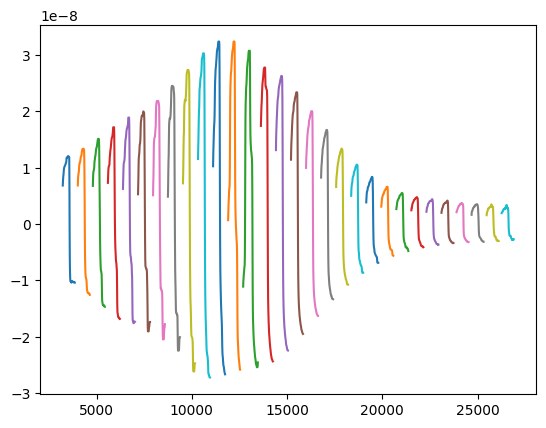

In [5]:
IPCE_df = pd.DataFrame([])
df = df_resampled.copy(deep=True)
df["Current"] = df["Photocurrent"].rolling(window=10).median()
for wavelength in df["Wavelength"].unique():
    mono_df = df.loc[df["Wavelength"] == wavelength][10:-5]
    mono_df.Current.plot()
    photocurrent = mono_df.Current.max() - mono_df.Current.min()
    new_row = pd.DataFrame({"Wavelength": wavelength, "Photocurrent": photocurrent}, index=[len(IPCE_df)])
    IPCE_df = pd.concat([IPCE_df, new_row])
px.line(IPCE_df, "Wavelength", ["Photocurrent"])

In [24]:
    import to_IPCE
    df = to_IPCE.read_data(r"c:\Users\butma\Downloads\Telegram Desktop\Калибровка 400С.txt")
    df = to_IPCE.reduction_smooth(df, window=1)
    df = to_IPCE.time_split(df)
    #df = to_IPCE.cut_baseline(df)
    df["Photocurrent"] = df["Current"] 
    df[["Time","Photocurrent"]].plot(x="Time")

KeyError: "['Photocurrent'] not in index"

<Axes: xlabel='Wavelength'>

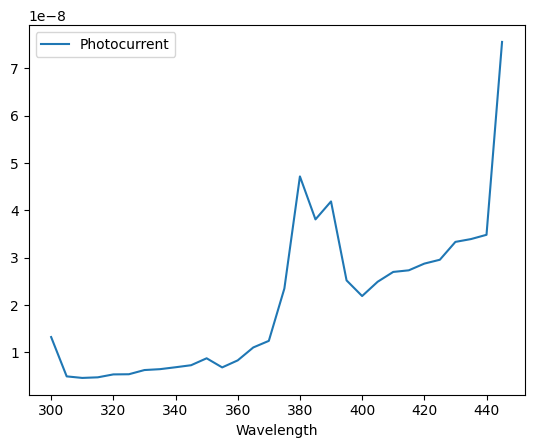

In [21]:
df = to_IPCE.get_photocurrent(df)
df.plot(x="Wavelength")